# Introducción

En este cuaderno evalúo diferentes algoritmos de regresión sobre una base que busca predecir la variación de la producción industrial de Estados Unidos a partir del PCE, el desempleo, el cambio en el circulante, cambio en las reservas bancarias, el PPI, el precio del petróleo (WTI), el rendimiento del T-bill de 3 meses, el rendimiento del T-note de 10 años y la pendiente de la curva de rendimientos de los Treasuries. 

Todos los datos son sacados de la API de la Reserva Federal de Saint Louis. Los datos tienen una frecuencia mensual. Para las variables que presentan una mayor frecuencia se les saca el promedio mensual.

En las primeras partes se hace un manejo de datos (donde se unifican las diferentes variables en una sola base de datos con la misma frecuencia y el mismo periodo de observaciones). Se hace un análisis estadístico y visual de las variables.

En la parte de la evaluación de los modelos se toman 2 medidas de rendimiento: el $R^2$ sobre la base de entrenamiento y los RMSE sobre la base de evaluación (que se aparta desde el inicio). Además, a lo largo del cuaderno se mide el tiempo que toma cada modelo para llegar al resultado (en los modelos finales, donde se utiliza *cross-validation* para seleccionar los mejores híper-parámetros no se mide esto debido a la carga computacional generada por las diferentes combinaciones. Los resultados se resumen en una tabla al final del cuaderno. 

Dado que se trabaja con series de tiempo, las variables utilizadas pueden tener auto correlación y no normalidad. Sin embargo, el objetivo del ejercicio es repasar los diferentes modelos y dar una primera aproximación para un análisis más profundo.


# Data Wrangling 

In [1]:
import pandas as pd
import numpy as np

In [2]:
key = "XXXXXXXXXXXXXXXXXXXXXXXXXXXXX"
from fredapi import Fred
fred = Fred(api_key = key)

In [4]:
pce = pd.DataFrame(fred.get_series(series_id = 'PCEPI', frequency = 'm', units = 'chg'))
unemployment = pd.DataFrame(fred.get_series(series_id = 'UNRATE', frequency = 'm'))
indu_produc = pd.DataFrame(fred.get_series(series_id = 'INDPRO', frequency = 'm', units = 'chg'))
cur_cir = pd.DataFrame(fred.get_series(series_id = 'WCURCIR', frequency = 'm', units ='chg'))
res_bal = pd.DataFrame(fred.get_series(series_id = 'WRESBAL', frequency = 'm', units = 'chg'))
t10yr = pd.DataFrame(fred.get_series(series_id = 'WGS10YR', frequency = 'm'))
t3m = pd.DataFrame(fred.get_series(series_id = 'WGS3MO', frequency = 'm'))
ppi = pd.DataFrame(fred.get_series(series_id = 'WPSID61', frequency = 'm',units = 'chg'))
wti = pd.DataFrame(fred.get_series(series_id = 'DCOILWTICO', frequency = 'm'))
pce.head()

,0
1959-01-01,NaN
1959-02-01,0.015
1959-03-01,0.011
1959-04-01,0.032
1959-05-01,0.008


In [5]:
df1 = pd.merge(pce, unemployment, how = 'inner', left_index = True, right_index=True)
df1 = pd.merge(df1, indu_produc, how = 'inner', left_index = True, right_index=True)
df1 = pd.merge(df1, cur_cir, how = 'inner', left_index = True, right_index=True)
df1 = pd.merge(df1, res_bal, how = 'inner', left_index = True, right_index=True)
df1 = pd.merge(df1, t3m, how = 'inner', left_index = True, right_index=True)
df1 = pd.merge(df1, t10yr, how = 'inner', left_index = True, right_index=True)
df1 = pd.merge(df1, ppi, how = 'inner', left_index = True, right_index=True)
df1 = pd.merge(df1, wti, how = 'inner', left_index = True, right_index=True)

In [6]:
cols=['PCEPI', 'UNRATE', 'INDPRO', 'WCURCIR', 'WRESBAL', 'WGS3MO', 'WGS10YR','PPI', 'WTI']
df1.columns = cols
#print(df1.columns)
df1["CURVSLP"] = df1["WGS10YR"]-df1["WGS3MO"]
df1.head()

,PCEPI,UNRATE,INDPRO,WCURCIR,WRESBAL,WGS3MO,WGS10YR,PPI,WTI,CURVSLP
1986-01-01,0.248,6.7,0.2646,-0.58845,-0.61085,7.29,9.17,-0.5,22.93,1.88
1986-02-01,0.000,7.2,-0.3760,-2.96930,-2.27440,7.29,8.70,-1.2,15.45,1.41
1986-03-01,-0.119,7.2,-0.3924,1.04650,2.44525,6.77,7.79,-1.3,12.61,1.02
1986-04-01,-0.111,7.1,0.0179,1.93600,1.66255,6.24,7.29,-1.0,12.84,1.05
1986-05-01,0.099,7.2,0.1224,2.10250,-0.34055,6.33,7.68,-0.2,15.38,1.35


In [6]:
#df0.dtypes
#par = list()
#for i in range(0,len(c)):
#    if i%2==0:
#        par.append(i)
#par

In [7]:
#df_cons = pd.DataFrame()
#df_cons["Date"] = df0["WRESBAL"]
#for name in cols:
#    df_cons[cols] = df0[cols]
#df_cons.replace('NaT',np.nan,inplace=True)
#df_cons.dropna(inplace=True)
#df_cons.columns

In [8]:
#for i, col_new in zip(par,range(0,len(par))):  
#    for j in range(0, len(df0)):
#        if type(df0.iloc[j,i]) == pd._libs.tslibs.timestamps.Timestamp:
#            for f in range(0,len(df_cons)):
#                try:
#                    if df0.iloc[j,i] == df_cons.iloc[f,0]:
#                        df_cons.iloc[f,col_new+1]= df0.iloc[j,i+1]
#                         #print(df0.iloc[j,i+1])
#                except: continue
#        else: 
#            #print(df0.iloc[j,i])
#            continue
        

In [7]:
df1.info

<bound method DataFrame.info of             PCEPI  UNRATE   INDPRO   WCURCIR     WRESBAL  WGS3MO  WGS10YR  \
1986-01-01  0.248     6.7   0.2646  -0.58845    -0.61085    7.29     9.17   
1986-02-01  0.000     7.2  -0.3760  -2.96930    -2.27440    7.29     8.70   
1986-03-01 -0.119     7.2  -0.3924   1.04650     2.44525    6.77     7.79   
1986-04-01 -0.111     7.1   0.0179   1.93600     1.66255    6.24     7.29   
1986-05-01  0.099     7.2   0.1224   2.10250    -0.34055    6.33     7.68   
...           ...     ...      ...       ...         ...     ...      ...   
2020-01-01  0.153     3.6  -0.4682   4.72465     7.92930    1.55     1.78   
2020-02-01  0.103     3.5   0.1401  -2.99440    11.33945    1.55     1.50   
2020-03-01 -0.273     4.4  -4.8606  30.11150   231.19250    0.31     0.89   
2020-04-01 -0.507    14.7 -13.2649  61.33470  1013.72445    0.15     0.67   
2020-05-01  0.106    13.3   1.2543  42.38830   319.11930    0.12     0.67   

            PPI    WTI  CURVSLP  
1986-01-0

# Statistical and Visual Analysis 

In [8]:
df1.describe()

,PCEPI,UNRATE,INDPRO,WCURCIR,WRESBAL,WGS3MO,WGS10YR,PPI,WTI,CURVSLP
count,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000
mean,0.136107,5.882082,0.085733,4.201139,7.716616,3.227676,4.916586,0.201211,44.084019,1.688910
std,0.159022,1.624156,0.896652,5.887462,71.246498,2.547728,2.234992,1.419549,29.031358,1.122325
min,-1.084000,3.500000,-13.264900,-28.535000,-195.014750,0.010000,0.670000,-9.700000,11.350000,-0.700000
25%,0.066000,4.700000,-0.173200,1.361500,-1.267400,0.700000,2.860000,-0.200000,19.740000,0.770000
50%,0.143000,5.600000,0.155800,3.138000,-0.001750,3.100000,4.720000,0.200000,31.110000,1.660000
75%,0.220000,6.700000,0.448200,5.903100,1.768800,5.250000,6.670000,0.800000,62.720000,2.630000
max,0.836000,14.700000,1.782400,61.334700,1013.724450,9.140000,9.550000,5.300000,133.880000,3.690000


In [9]:
# Correlation Matrix
corr_matrix = df1.corr()
corr_matrix

,PCEPI,UNRATE,INDPRO,WCURCIR,WRESBAL,WGS3MO,WGS10YR,PPI,WTI,CURVSLP
PCEPI,1.000000,-0.077110,0.225675,-0.264140,-0.317933,0.128074,0.129341,0.790571,0.129652,-0.033165
UNRATE,-0.077110,1.000000,-0.165348,0.204044,0.365479,-0.364907,-0.108745,-0.049522,0.262877,0.611799
INDPRO,0.225675,-0.165348,1.000000,-0.400408,-0.588732,0.097992,0.144988,0.299314,-0.008147,0.066282
WCURCIR,-0.264140,0.204044,-0.400408,1.000000,0.489459,-0.386433,-0.430055,-0.253416,0.187335,0.020810
WRESBAL,-0.317933,0.365479,-0.588732,0.489459,1.000000,-0.150547,-0.143917,-0.320770,0.068151,0.055154
WGS3MO,0.128074,-0.364907,0.097992,-0.386433,-0.150547,1.000000,0.897982,0.045989,-0.653239,-0.481808
WGS10YR,0.129341,-0.108745,0.144988,-0.430055,-0.143917,0.897982,1.000000,0.074906,-0.688447,-0.047066
PPI,0.790571,-0.049522,0.299314,-0.253416,-0.320770,0.045989,0.074906,1.000000,0.191705,0.044771
WTI,0.129652,0.262877,-0.008147,0.187335,0.068151,-0.653239,-0.688447,0.191705,1.000000,0.111913
CURVSLP,-0.033165,0.611799,0.066282,0.020810,0.055154,-0.481808,-0.047066,0.044771,0.111913,1.000000


In [10]:
corr_matrix["INDPRO"].sort_values(ascending = False)

INDPRO     1.000000
PPI        0.299314
PCEPI      0.225675
WGS10YR    0.144988
WGS3MO     0.097992
CURVSLP    0.066282
WTI       -0.008147
UNRATE    -0.165348
WCURCIR   -0.400408
WRESBAL   -0.588732
Name: INDPRO, dtype: float64

In [11]:
list_0 = df1[["PPI","INDPRO","PCEPI"]]
list_1 = df1[["CURVSLP","UNRATE",'WGS3MO', 'WGS10YR']]
list_2 = df1[["WTI","WRESBAL"]]

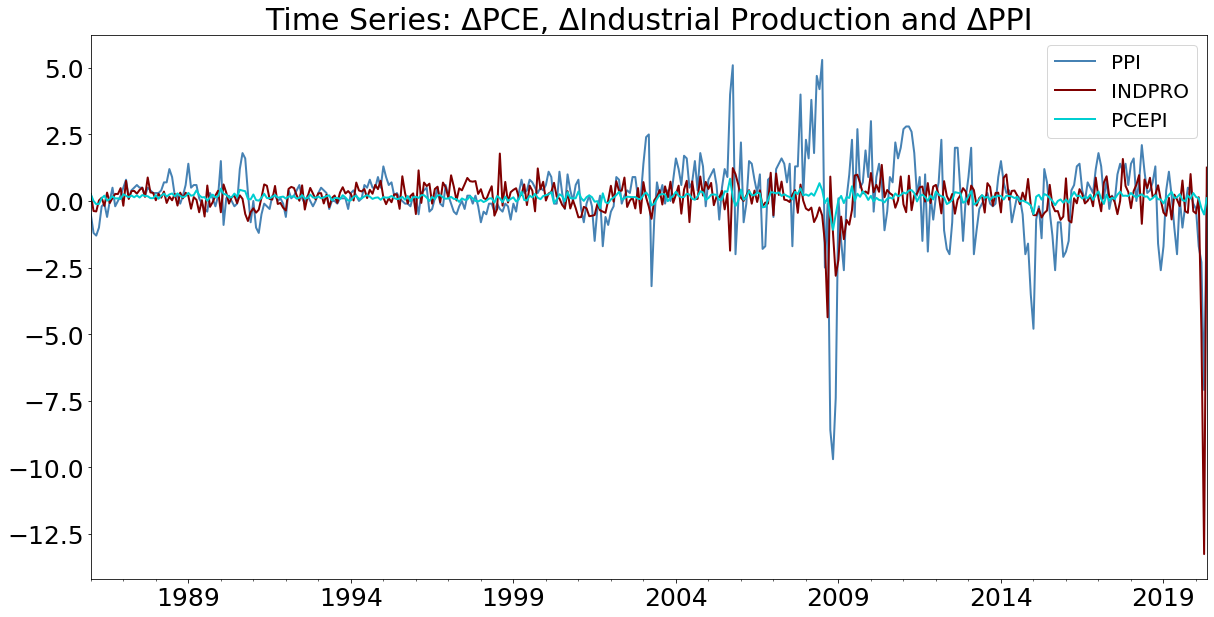

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
list_0.plot(kind ='line', color = ["steelblue","maroon","darkturquoise"], linewidth=2, figsize=(20,10), fontsize= 25)
plt.title("Time Series: ΔPCE, ΔIndustrial Production and ΔPPI", fontsize = 30)
plt.legend(fontsize=20)
plt.show()

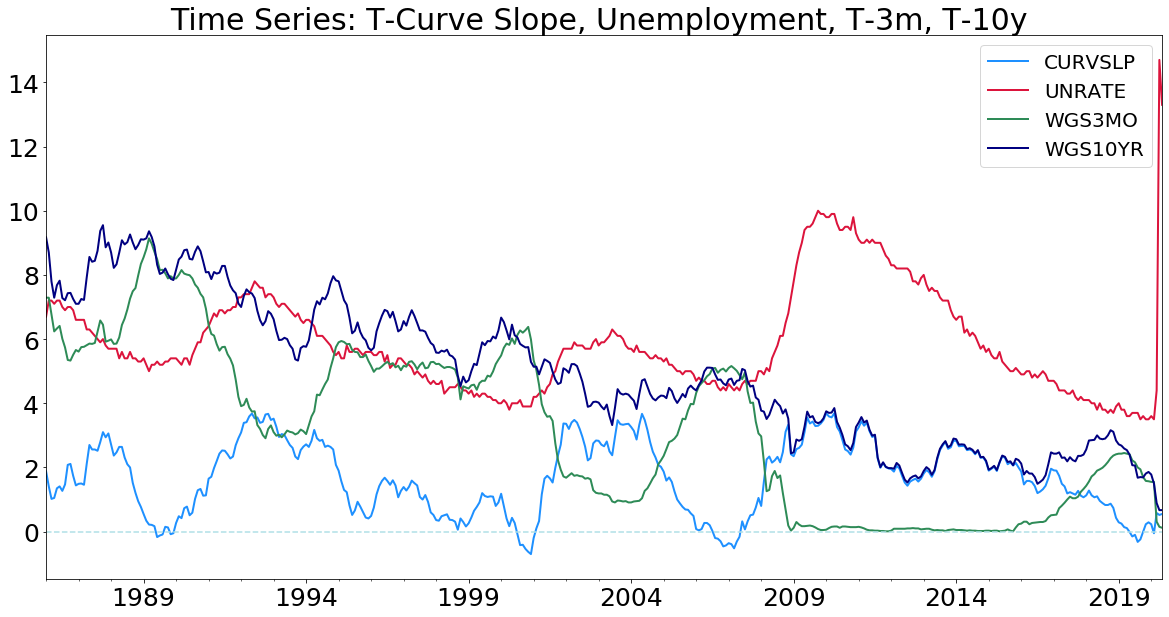

In [13]:
list_1.plot(kind = 'line', color = ["dodgerblue", "crimson", "seagreen", "navy"],linewidth=2, figsize=(20,10), fontsize= 25)
plt.title("Time Series: T-Curve Slope, Unemployment, T-3m, T-10y ", fontsize = 30)
plt.axhline(y=0, color = "powderblue", linestyle = "--")
plt.legend(fontsize=20)
plt.show()

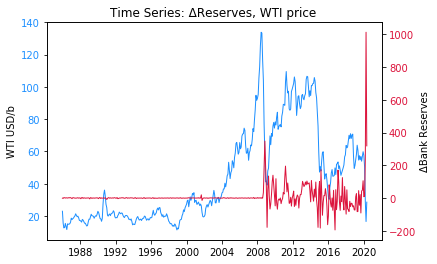

In [14]:
#list_2.plot(kind = 'line', color = ["dodgerblue", "crimson"],linewidth=2, figsize=(20,10), fontsize= 25)
fig,ax1 = plt.subplots()
ax1.set_ylabel('WTI USD/b')
ax1.plot(df1["WTI"], color = "dodgerblue",linewidth=1)
ax1.tick_params(axis='y', labelcolor = 'dodgerblue')

ax2=ax1.twinx()
ax2.set_ylabel('ΔBank Reserves')
ax2.plot(df1["WRESBAL"], color = "crimson",linewidth=1)
ax2.tick_params(axis='y', labelcolor = 'crimson')
plt.title("Time Series: ΔReserves, WTI price ")
plt.show()

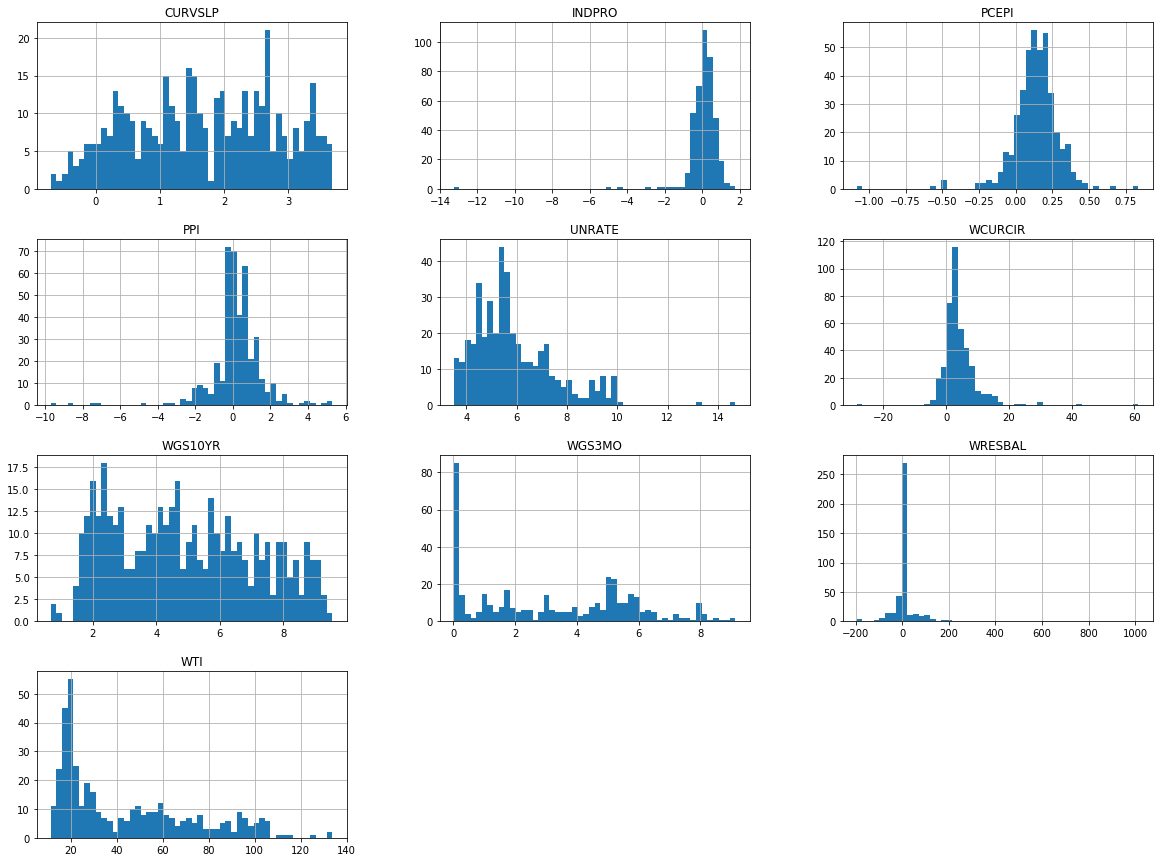

In [15]:

df1.hist(bins = 50, figsize=(20,15))
plt.show()

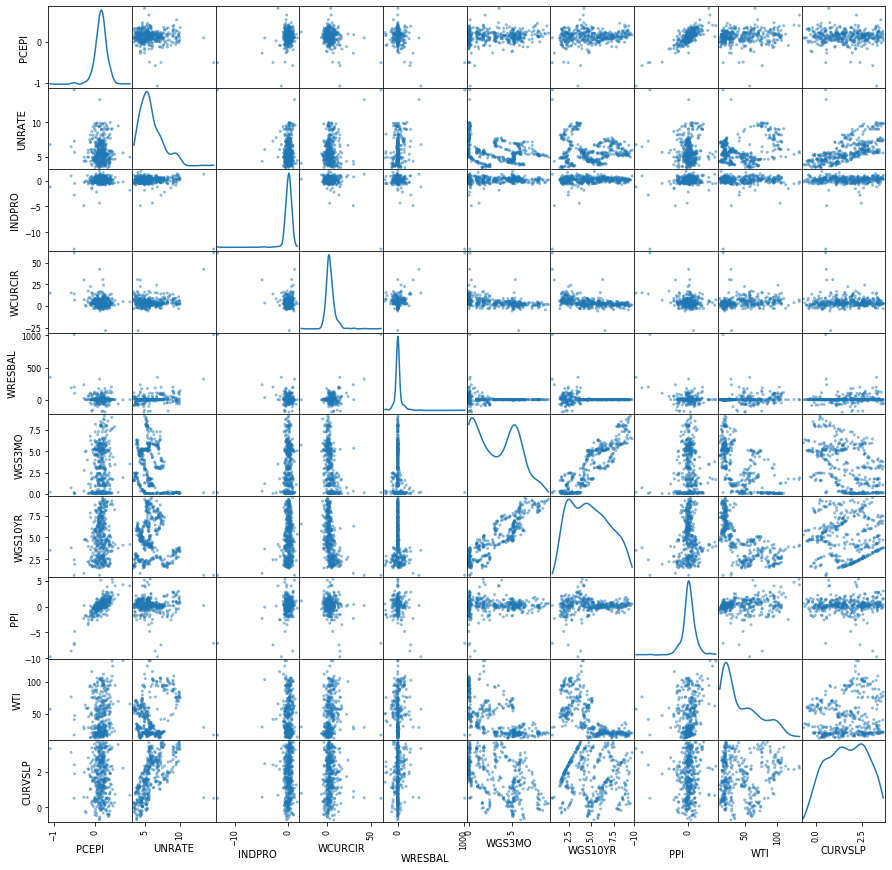

In [16]:
from pandas.plotting import scatter_matrix
scatter_matrix(df1,figsize=(15,15), diagonal = 'kde')
plt.show()

# Regression Models 

In [17]:
X = np.asanyarray(df1[['PCEPI', 'UNRATE', 'WCURCIR', 'WRESBAL', 'WGS3MO', 'WGS10YR','PPI', 'WTI','CURVSLP']])
y = np.asanyarray(df1[['INDPRO']])
variables = ['PCEPI', 'UNRATE', 'WCURCIR', 'WRESBAL', 'WGS3MO', 'WGS10YR','PPI', 'WTI','CURVSLP']

In [18]:
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

#Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 10)

In [19]:
y_train.shape,X_train.shape

((330, 1), (330, 9))

## Plain Vanilla Linear Regression (SVD): 

### The time spent by the algorithm to adjust best parameters:

In [20]:
lin_reg = LinearRegression()

In [21]:
%%timeit
#Linear Regression plain vanilla:
lin_reg.fit(X_train,y_train)

456 µs ± 137 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Results

In [23]:
print("Intercept:",lin_reg.intercept_[0], "Thetas:",lin_reg.coef_[0])
for theta, var in zip(lin_reg.coef_[0],variables):
    print(var,":",theta)

y_h = lin_reg.predict(X_train)
y_hat = lin_reg.predict(X_test)
rmse_lin_PV = np.sqrt(metrics.mean_squared_error(y_test,y_hat))
print("R2-score on train:%.4f"%metrics.r2_score(y_train,y_h))
print("RMSE on test:%.4f"%rmse_lin_PV)

Intercept: -0.10861268719259407 Thetas: [-0.04335044  0.02915429 -0.01492319 -0.00737161 -0.01969405  0.02421658
  0.09418179  0.00045617  0.04391063]
PCEPI : -0.04335044317808065
UNRATE : 0.029154288781988225
WCURCIR : -0.014923192611793753
WRESBAL : -0.007371610826248675
WGS3MO : -0.019694054644983847
WGS10YR : 0.02421657752549526
PPI : 0.09418178557129235
WTI : 0.00045616565981728915
CURVSLP : 0.04391063217047911
R2-score on train:0.4533
RMSE on test:0.7235


## Linear Regression: Stochastic Gradient Descent 

In [24]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

### Standarizing the predictor matrix: 

In [25]:
#Normilizing the data in order to accelerate the convergence process:
sgd_reg = SGDRegressor(max_iter=1000, tol=0.001, penalty=None,learning_rate='optimal')
std_scaler = StandardScaler()
Xs_train = std_scaler.fit_transform(X_train)
Xs_test = std_scaler.transform(X_test)
type(Xs_train)

numpy.ndarray

## Cross-validation to select best hyperparameters 

In [26]:
from sklearn.model_selection import GridSearchCV

param_grid=[{'fit_intercept':[True,False], 'learning_rate':['invscaling','constant','optimal','adaptive']}]
grid_search = GridSearchCV(sgd_reg, param_grid, cv=10,
                          scoring='neg_mean_squared_error',
                          return_train_score=True)
grid_search.fit(Xs_train,y_train.ravel())

GridSearchCV(cv=10, error_score=nan,
             estimator=SGDRegressor(alpha=0.0001, average=False,
                                    early_stopping=False, epsilon=0.1,
                                    eta0=0.01, fit_intercept=True,
                                    l1_ratio=0.15, learning_rate='optimal',
                                    loss='squared_loss', max_iter=1000,
                                    n_iter_no_change=5, penalty=None,
                                    power_t=0.25, random_state=None,
                                    shuffle=True, tol=0.001,
                                    validation_fraction=0.1, verbose=0,
                                    warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'fit_intercept': [True, False],
                          'learning_rate': ['invscaling', 'constant', 'optimal',
                                            'adaptive']}],
             pre_dispatch='2*n_jobs', refit

### Best Hyperparameters

In [27]:
grid_search.best_params_

{'fit_intercept': False, 'learning_rate': 'adaptive'}

In [28]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.9804435840827617 {'fit_intercept': True, 'learning_rate': 'invscaling'}
1.177369059315859 {'fit_intercept': True, 'learning_rate': 'constant'}
4920394801886.484 {'fit_intercept': True, 'learning_rate': 'optimal'}
0.9641034203856723 {'fit_intercept': True, 'learning_rate': 'adaptive'}
0.9748561147461834 {'fit_intercept': False, 'learning_rate': 'invscaling'}
1.2837365883516179 {'fit_intercept': False, 'learning_rate': 'constant'}
3404214307847.4224 {'fit_intercept': False, 'learning_rate': 'optimal'}
0.9609426281355606 {'fit_intercept': False, 'learning_rate': 'adaptive'}


In [29]:
sgd_reg = SGDRegressor(max_iter=1000, tol=0.001, penalty=None,learning_rate='adaptive', fit_intercept=False)

### Time spent by the algorithm to converge to an answer 

In [30]:
%%timeit
sgd_reg.fit(Xs_train,y_train.ravel())

1.02 ms ± 43.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Results 

In [31]:
print("Intercept:",sgd_reg.intercept_[0], "Thetas:",sgd_reg.coef_)
for t, var in zip(sgd_reg.coef_,variables):
    print(var,":",t)

y_hsgd = sgd_reg.predict(Xs_train)
y_hatsgd = sgd_reg.predict(Xs_test)
rmse_sgd = np.sqrt(metrics.mean_squared_error(y_test,y_hatsgd))
print("R2-score on train:%.4f"%metrics.r2_score(y_train,y_hsgd))
print("RMSE on test:%.4f"%rmse_sgd)

Intercept: 0.0 Thetas: [-0.0035756   0.01701565 -0.09669264 -0.57984127 -0.01487643  0.02740355
  0.12430286  0.03491095  0.08989693]
PCEPI : -0.0035756028472436175
UNRATE : 0.017015652395348534
WCURCIR : -0.09669263727034742
WRESBAL : -0.5798412725816536
WGS3MO : -0.014876431830715521
WGS10YR : 0.02740354854500222
PPI : 0.12430285584402162
WTI : 0.03491095174567337
CURVSLP : 0.08989693268494328
R2-score on train:0.4420
RMSE on test:0.7274


## Polynomial Regresion 

### Second-Degree Polynomial Regression

In [32]:
# Polynomial features
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree = 2, include_bias = True)
X_poly_train = poly_features.fit_transform(X_train)
X_poly_test = poly_features.fit_transform(X_test)

plin_reg=LinearRegression()

In [33]:
%%timeit
plin_reg.fit(X_poly_train,y_train)

1.27 ms ± 489 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Results 

In [34]:
y_hpr = plin_reg.predict(X_poly_train)
y_hatpr = plin_reg.predict(X_poly_test)
rmse_pr2 = np.sqrt(metrics.mean_squared_error(y_test,y_hatpr))
print(plin_reg.intercept_,plin_reg.coef_, len(plin_reg.coef_[0]))
print("R2-score on train:%.4f"%metrics.r2_score(y_train,y_hpr))
print("RMSE on test:%.4f"%rmse_pr2)

[-0.110186] [[ 1.08610406e-11 -2.25387690e+00 -5.79410014e-01 -9.91702876e-02
  -9.18744499e-03  1.38102087e-01  4.34492215e-01  6.27305795e-01
   4.23829014e-02  2.96390129e-01  1.02480843e+00  1.96627162e-01
   1.47847836e-02  1.11315955e-02  6.25469225e-02  6.60693592e-02
  -1.30498876e-01  4.47731208e-03  3.52243669e-03  5.87457876e-02
  -1.24957744e-04  5.91295951e-04 -2.08778354e-03 -2.49377249e-02
  -4.73010062e-02 -1.49392196e-03 -2.28499413e-02  1.82219729e-04
   5.28166416e-05  5.53867775e-03  5.55004702e-03  8.25758591e-04
   1.33419998e-03  1.13692668e-05 -1.26664408e-05 -6.68956435e-05
  -1.48726271e-03 -8.59123149e-05  1.37495069e-04 -1.42036707e-03
  -7.62651485e-03 -8.02938583e-03 -2.96535396e-03 -2.02349370e-03
  -4.02870980e-04 -1.26857504e-02 -3.06094232e-02 -2.81065199e-03
  -4.65636458e-03  3.05375556e-02 -1.81212827e-03 -2.76440693e-02
  -2.21203270e-04 -7.87158287e-04 -4.25349360e-03]] 55
R2-score on train:0.7651
RMSE on test:0.7846


### 10th-degree Poylinomial Regression: Overfitting 

In [35]:
poly_features10 = PolynomialFeatures(degree = 10, include_bias = True)
X_poly_train10 = poly_features10.fit_transform(X_train)
X_poly_test10 = poly_features10.fit_transform(X_test)

In [36]:
%%timeit
plin_reg.fit(X_poly_train10,y_train)

2.74 s ± 51.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Results 

In [37]:
y_hpr = plin_reg.predict(X_poly_train10)
y_hatpr = plin_reg.predict(X_poly_test10)
rmse_pr10tn = np.sqrt(metrics.mean_squared_error(y_train,y_hpr))
rmse_pr10tt = np.sqrt(metrics.mean_squared_error(y_test,y_hatpr))
print("R2-score on train:%.2f"%metrics.r2_score(y_train,y_hpr))
print("RMSE on test:%.2f"%rmse_pr10tt)
print("RMSE on train:%.2f"%rmse_pr10tn)

R2-score on train:0.89
RMSE on test:1689423.38
RMSE on train:0.31


## Selecting the best polynomial model 

In [49]:
dict(poly_features__degree=d, poly_features__include_bias=[True,False])
param_grid

{'poly_features__degree': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}

In [53]:
d

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [55]:
from sklearn.model_selection import GridSearchCV
d = np.arange(1,11).tolist()

poly_features = PolynomialFeatures(degree=2)
lin_reg = LinearRegression()
poly_reg = Pipeline([("poly_features",poly_features),
                      ("lin_reg",lin_reg)])
param_grid= dict(poly_features__degree=d, poly_features__include_bias=[True,False])
grid_search=GridSearchCV(poly_reg, param_grid, cv=10,
                         scoring='neg_mean_squared_error',
                         return_train_score=True, verbose=0)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('poly_features',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('lin_reg',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'poly_features__degree': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                            

In [56]:
grid_search.best_params_

{'poly_features__degree': 2, 'poly_features__include_bias': False}

In [66]:
grid_search.best_estimator_

Pipeline(memory=None,
         steps=[('poly_features',
                 PolynomialFeatures(degree=2, include_bias=False,
                                    interaction_only=False, order='C')),
                ('lin_reg',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [63]:
y_ht = grid_search.predict(X_train)
y_htt = grid_search.predict(X_test)
rmse_prbestt = np.sqrt(metrics.mean_squared_error(y_train,y_ht))
rmse_prbest = np.sqrt(metrics.mean_squared_error(y_test,y_htt))
print("R2-score on train:%.4f"%metrics.r2_score(y_train,y_ht))
print("RMSE on test:%.4f"%rmse_prbest)
print("RMSE on train:%.4f"%rmse_prbestt)

R2-score on train:0.7651
RMSE on test:0.7846
RMSE on train:0.4626


In [58]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(" mean RMSE:", np.sqrt(-mean_score), params)

 mean RMSE: 0.9599586425369232 {'poly_features__degree': 1, 'poly_features__include_bias': True}
 mean RMSE: 0.9599586425369233 {'poly_features__degree': 1, 'poly_features__include_bias': False}
 mean RMSE: 0.9549172142711898 {'poly_features__degree': 2, 'poly_features__include_bias': True}
 mean RMSE: 0.8656645250460855 {'poly_features__degree': 2, 'poly_features__include_bias': False}
 mean RMSE: 9.196253546913947 {'poly_features__degree': 3, 'poly_features__include_bias': True}
 mean RMSE: 9.132145248903727 {'poly_features__degree': 3, 'poly_features__include_bias': False}
 mean RMSE: 81066.8574298223 {'poly_features__degree': 4, 'poly_features__include_bias': True}
 mean RMSE: 81066.85747148417 {'poly_features__degree': 4, 'poly_features__include_bias': False}
 mean RMSE: 1175239.609214583 {'poly_features__degree': 5, 'poly_features__include_bias': True}
 mean RMSE: 1175239.607515475 {'poly_features__degree': 5, 'poly_features__include_bias': False}
 mean RMSE: 161970757.65527594 {

# Regularized Models 

## Ridge Regression

In [67]:
from sklearn.linear_model import Ridge
alphas = np.arange(0,5,0.1).tolist()

ridge_reg = Ridge(alpha=0,solver="svd", random_state=42)
ridge_poly = Pipeline([
    ("poly_features", PolynomialFeatures(degree=2)),
    ("std_scaler",StandardScaler()),
    ("ridge_reg",ridge_reg)
])
param_grid=dict(ridge_reg__alpha= alphas, poly_features__degree = [1,2,3,4,5],
               poly_features__include_bias=[True,False])

### Cross-Validation

In [68]:
grid_search = GridSearchCV(ridge_poly, param_grid, cv=10,
                         scoring='neg_mean_squared_error',
                         return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('poly_features',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('std_scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('ridge_reg',
                                        Ridge(alpha=0, copy_X=True,
                                              fit_intercept=True, max_iter=None,
                                              normalize=False, random_state=42,
              

### Best hyperparameters

In [71]:
grid_search.best_params_

{'poly_features__degree': 2,
 'poly_features__include_bias': False,
 'ridge_reg__alpha': 1.3}

In [69]:
grid_search.best_estimator_

Pipeline(memory=None,
         steps=[('poly_features',
                 PolynomialFeatures(degree=2, include_bias=False,
                                    interaction_only=False, order='C')),
                ('std_scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('ridge_reg',
                 Ridge(alpha=1.3, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=42,
                       solver='svd', tol=0.001))],
         verbose=False)

In [70]:
y_ht = grid_search.predict(X_train)
y_htt = grid_search.predict(X_test)
rmse_rdgt = np.sqrt(metrics.mean_squared_error(y_train,y_ht))
rmse_rdg = np.sqrt(metrics.mean_squared_error(y_test,y_htt))
print("R2-score on train:%.4f"%metrics.r2_score(y_train,y_ht))
print("RMSE on test:%.4f"%rmse_rdg)
print("RMSE on train:%.4f"%rmse_rdgt)

R2-score on train:0.7568
RMSE on test:0.7768
RMSE on train:0.4707


In [72]:
pipe_ridge = Pipeline([
    ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
    ("std_scaler",StandardScaler())])
X_trainpr = pipe_ridge.fit_transform(X_train)
X_testpr = pipe_ridge.transform(X_test)
ridge_reg = Ridge(alpha=1.3,solver="svd", random_state=42)

In [73]:
%%timeit
ridge_reg.fit(X_trainpr,y_train)

1.65 ms ± 82.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Results

In [74]:
y_hrpr = ridge_reg.predict(X_trainpr)
y_hatrpr = ridge_reg.predict(X_testpr)
rmse_rpr10tn = np.sqrt(metrics.mean_squared_error(y_train,y_hrpr))
rmse_rpr10tt = np.sqrt(metrics.mean_squared_error(y_test,y_hatrpr))
print("R2-score on train:%.4f"%metrics.r2_score(y_train,y_hrpr))
print("RMSE on test:%.4f"%rmse_rpr10tt)
print("RMSE on train:%.4f"%rmse_rpr10tn)

R2-score on train:0.7568
RMSE on test:0.7768
RMSE on train:0.4707


## Lasso Regression

In [75]:
from sklearn.linear_model import Lasso
alphas = np.arange(0.1,5,0.1).tolist()
lasso_reg = Lasso(alpha=0.1, random_state=42)

In [76]:
lasso_reg?

Type:        Lasso
String form:
Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=42,
      selection='cyclic', tol=0.0001, warm_start=False)
File:        c:\users\alejandro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py
Docstring:  
Linear Model trained with L1 prior as regularizer (aka the Lasso)

The optimization objective for Lasso is::

    (1 / (2 * n_samples)) * ||y - Xw||^2_2 + alpha * ||w||_1

Technically the Lasso model is optimizing the same objective function as
the Elastic Net with ``l1_ratio=1.0`` (no L2 penalty).

Read more in the :ref:`User Guide <lasso>`.

Parameters
----------
alpha : float, optional
    Constant that multiplies the L1 term. Defaults to 1.0.
    ``alpha = 0`` is equivalent to an ordinary least square, solved
    by the :class:`LinearRegression` object. For numerical
    reasons, using ``alpha = 0`` with the ``Lasso`` object is not advised.
   

In [77]:
lasso_poly = Pipeline([
    ("poly_features", PolynomialFeatures(degree=2)),
    ("std_scaler",StandardScaler()),
    ("lasso_reg",lasso_reg)
])
param_grid=dict(lasso_reg__alpha= alphas, poly_features__degree = [1,2,3,4,5],
               poly_features__include_bias=[True, False], 
                lasso_reg__fit_intercept=[True,False])

### Cross-validation: selection of best hyperparameters 

In [78]:
grid_search = GridSearchCV(lasso_poly, param_grid, cv=10,
                         scoring='neg_mean_squared_error',
                         return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('poly_features',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('std_scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('lasso_reg',
                                        Lasso(alpha=0.1, copy_X=True,
                                              fit_intercept=True, max_iter=1000,
                                              normalize=False, positive=False,
             

In [79]:
grid_search.best_params_

{'lasso_reg__alpha': 0.2,
 'lasso_reg__fit_intercept': True,
 'poly_features__degree': 3,
 'poly_features__include_bias': True}

In [81]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.9944675021810798 {'lasso_reg__alpha': 0.1, 'lasso_reg__fit_intercept': True, 'poly_features__degree': 1, 'poly_features__include_bias': True}
0.9944675021810798 {'lasso_reg__alpha': 0.1, 'lasso_reg__fit_intercept': True, 'poly_features__degree': 1, 'poly_features__include_bias': False}
0.8836957363747043 {'lasso_reg__alpha': 0.1, 'lasso_reg__fit_intercept': True, 'poly_features__degree': 2, 'poly_features__include_bias': True}
0.8836957363747043 {'lasso_reg__alpha': 0.1, 'lasso_reg__fit_intercept': True, 'poly_features__degree': 2, 'poly_features__include_bias': False}
0.7306530507322091 {'lasso_reg__alpha': 0.1, 'lasso_reg__fit_intercept': True, 'poly_features__degree': 3, 'poly_features__include_bias': True}
0.7306530507322091 {'lasso_reg__alpha': 0.1, 'lasso_reg__fit_intercept': True, 'poly_features__degree': 3, 'poly_features__include_bias': False}
5.1983265444306275 {'lasso_reg__alpha': 0.1, 'lasso_reg__fit_intercept': True, 'poly_features__degree': 4, 'poly_features__include_bi

In [80]:
y_htlr = grid_search.predict(X_train)
y_httlr = grid_search.predict(X_test)
rmse_lssrt = np.sqrt(metrics.mean_squared_error(y_train,y_htlr))
rmse_lssr = np.sqrt(metrics.mean_squared_error(y_test,y_httlr))
print("R2-score on train:%.4f"%metrics.r2_score(y_train,y_htlr))
print("RMSE on test:%.4f"%rmse_lssr)
print("RMSE on train:%.4f"%rmse_lssrt)

R2-score on train:0.6027
RMSE on test:0.6000
RMSE on train:0.6015


In [82]:
pipe_lasso = Pipeline([
    ("poly_features", PolynomialFeatures(degree=3, include_bias=True)),
    ("std_scaler",StandardScaler())])
X_trainpr = pipe_lasso.fit_transform(X_train)
X_testpr = pipe_lasso.transform(X_test)
lasso_reg = Lasso(alpha=0.2, fit_intercept= True,random_state=42)

In [83]:
%%timeit
lasso_reg.fit(X_train,y_train)

597 µs ± 31.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Elastic Net

In [87]:
from sklearn.linear_model import ElasticNet
alphas = np.arange(0.1,5,0.1).tolist()
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5,max_iter = 10000, random_state=42)

In [96]:
l1 = np.arange(0,1.1,0.1).tolist()
l1

[0.0,
 0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6000000000000001,
 0.7000000000000001,
 0.8,
 0.9,
 1.0]

### Cross-Validation

In [99]:
en_poly = Pipeline([
    ("poly_features", PolynomialFeatures(degree=2)),
    ("std_scaler",StandardScaler()),
    ("en_reg",elastic_net)
])
param_grid = dict(poly_features__degree=list(range(1,6)), 
                  poly_features__include_bias=[True,False],
                  en_reg__alpha=alphas,
                  en_reg__l1_ratio=l1)

In [100]:
grid_search = GridSearchCV(en_poly,param_grid, cv=10,
                          scoring='neg_mean_squared_error',
                         return_train_score=True)
grid_search.fit(X_train, y_train)

C:\Users\ALEJANDRO\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 83.85784448241532, tolerance: 0.028838786881878794
  positive)
C:\Users\ALEJANDRO\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53.25720676696278, tolerance: 0.011613338760249158
  positive)
C:\Users\ALEJANDRO\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69.67021505138327, tolerance: 0.029006649896693604
  positive)
C:\Users\ALEJANDRO\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('poly_features',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('std_scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('en_reg',
                                        ElasticNet(alpha=0.1, copy_X=True,
                                                   fit_intercept=True,
                                                   l1_ratio=0.5, max_iter=1000,
                    

In [101]:
grid_search.best_params_

{'en_reg__alpha': 1.2000000000000002,
 'en_reg__l1_ratio': 0.1,
 'poly_features__degree': 3,
 'poly_features__include_bias': True}

### Results 

In [102]:
y_hten = grid_search.predict(X_train)
y_htten = grid_search.predict(X_test)
rmse_ent = np.sqrt(metrics.mean_squared_error(y_train,y_hten))
rmse_en = np.sqrt(metrics.mean_squared_error(y_test,y_htten))
print("R2-score on train:%.4f"%metrics.r2_score(y_train,y_hten))
print("RMSE on test:%.4f"%rmse_en)
print("RMSE on train:%.4f"%rmse_ent)

R2-score on train:0.6089
RMSE on test:0.6316
RMSE on train:0.5969


# Resumen 

In [103]:
data = [['Regresión Lineal SVD',0.7235,0.4533],['RL Stochastic Gradient Descent',0.7274,0.4420],
       ['Regresión Polinómica grado 2 simple',0.7846,0.7651],['Reg Pol g.10',1689423.38,0.89],
       ['Ridge Regression',0.7768,0.7568],['Lasso Regression',0.6000,0.6027],
       ['Elastic Net',0.6316,0.6089]]
resumen =pd.DataFrame(data, columns = ["Modelo","RMSE","R2"])
resumen

,Modelo,RMSE,R2
0,Regresión Lineal SVD,7.235000e-01,0.4533
1,RL Stochastic Gradient Descent,7.274000e-01,0.4420
2,Regresión Polinómica grado 2 simple,7.846000e-01,0.7651
3,Reg Pol g.10,1.689423e+06,0.8900
4,Ridge Regression,7.768000e-01,0.7568
5,Lasso Regression,6.000000e-01,0.6027
6,Elastic Net,6.316000e-01,0.6089
